In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras import models, layers

In [4]:
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
Dataset = tf.keras.preprocessing.image_dataset_from_directory('Plant_Dataset', shuffle = True, 
                                                              image_size = (IMAGE_SIZE, IMAGE_SIZE), batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = Dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(Dataset)

68

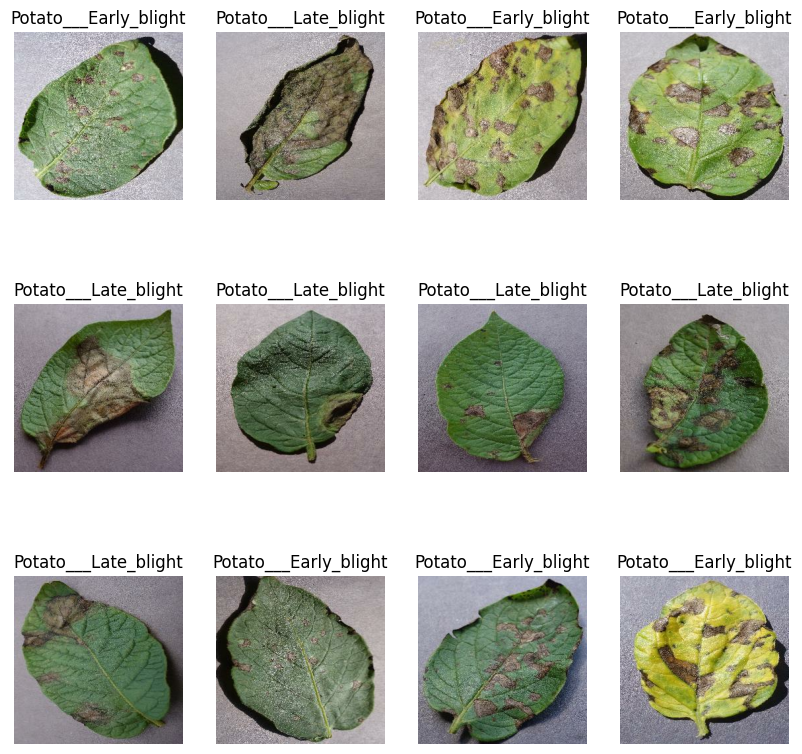

In [9]:
plt.figure(figsize=(10,10))   #increase the area
for image_batch, label_batch in Dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)   #to display all the images
        plt.imshow(image_batch[i].numpy().astype("uint8"))   
        plt.title(class_names[label_batch[i]])
        
        plt.axis('off')
   

In [10]:
# 80% => training
# 20% => 10% validation, 10% testing

In [11]:
train_size = 0.8
len(Dataset)*train_size   #this batch data set will be for training purpose

54.400000000000006

In [12]:
train_ds = Dataset.take(54)  # first 54 batches
len(train_ds)

54

In [13]:
#validation and test datset
test_ds = Dataset.skip(54)
len(test_ds)


14

In [14]:
val_size = .1
len(Dataset)*val_size # out of 14, this is the validation dataset

6.800000000000001

In [15]:
val_ds = test_ds.take(6)  
len(val_ds)   # validation dataset

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)   # testing dataset

8

In [17]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    """
    Splits a dataset into training, validation, and test sets.
    
    Args:
        ds: Input dataset
        train_split: Proportion for training (default: 0.8)
        val_split: Proportion for validation (default: 0.1) 
        test_split: Proportion for testing (default: 0.1)
        shuffle: Whether to shuffle the dataset (default: True)
        shuffle_size: Buffer size for shuffling (default: 10000)
    
    Returns:
        train_ds, val_ds, test_ds: Training, validation, and test datasets
    """
    # Shuffle the dataset if requested
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    # Calculate dataset sizes
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    # Split the dataset correctly
    train_ds = ds.take(train_size)                                    # First train_size batches
    val_ds = ds.skip(train_size).take(val_size)                     # Next val_size batches  
    test_ds = ds.skip(train_size + val_size)                        # Remaining batches
    
    return train_ds, val_ds, test_ds
    

In [18]:
train_ds, val_ds, test_ds = get_dataset_partition(Dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

In [22]:
#tensorflow determine , how many batches GPU is loading
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [23]:
resize_and_rescaling = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Updated: removed 'experimental.preprocessing'
    layers.Rescaling(1.0/255)  # Updated: normalize pixel values to [0,1]
])

In [24]:
data_augumantation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

In [25]:
#create neural architecture
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Shape without batch size for Input layer
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Shape with batch size
n_classes = 3

# Build the CNN model
model = models.Sequential([
    layers.Input(batch_shape=batch_input_shape),  # Use batch_shape to include BATCH_SIZE
    resize_and_rescaling,
    data_augumantation,
    layers.Conv2D(32, (3,3), activation='relu'),  # Now this will work correctly
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')               
])


# The model will automatically build when we add the Input layer
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Fixed: "Categorical" not "Categoral"
    metrics=['accuracy']
)

In [27]:
# fit and train the model

In [28]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.4441 - loss: 0.9257 - val_accuracy: 0.6510 - val_loss: 0.7239
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6289 - loss: 0.6927 - val_accuracy: 0.7865 - val_loss: 0.4440
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7933 - loss: 0.4718 - val_accuracy: 0.8021 - val_loss: 0.4409
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.8180 - loss: 0.4107 - val_accuracy: 0.8542 - val_loss: 0.3471
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8742 - loss: 0.3067 - val_accuracy: 0.8958 - val_loss: 0.2392
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9037 - loss: 0.2496 - val_accuracy: 0.9531 - val_loss: 0.1283
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 690s 13s/step - accuracy: 0.9066 - loss: 0.2311 - val_accuracy: 0.9115 - val_loss: 0.2139
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9125 - loss: 0.2140 - val_accuracy: 0.9531 - val_l

In [36]:
#test the model
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.9733 - loss: 0.0755


In [37]:
scores

[0.1018795371055603, 0.95703125]

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

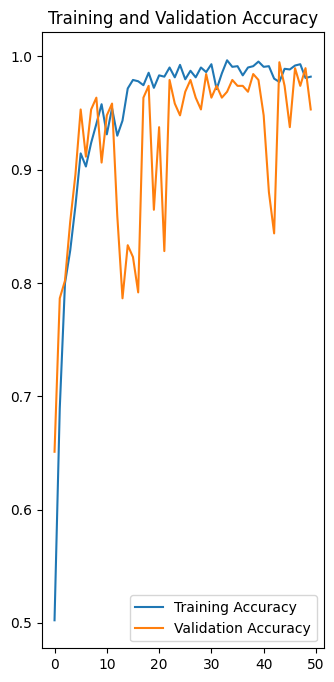

In [41]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


#plt.figure(figsize=(8,8))
#plt.subplot(1,2,1)
#plt.plot(range(EPOCHS),loss,label='Training Loss')
#plt.plot(range(EPOCHS),val_acc,label='Validation Loss')
#plt.legend(loc='upper right')
#plt.title('Training and Validation Accuracy')








In [44]:
np.argmax([1.7648037e-05,9.9998021e-01,2.0811085e-06])

np.int64(1)

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Predicated Label: Potato___Early_blight


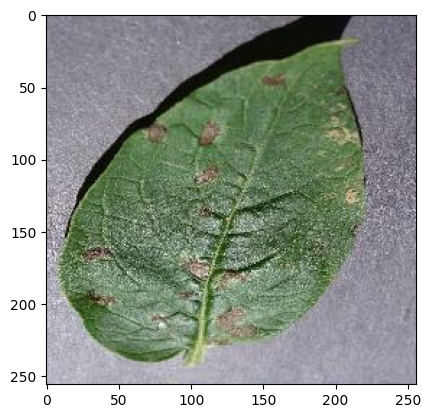

In [45]:
import numpy as np
for images_batch , labels_batch in test_ds.take(1):
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label.numpy()])

    batch_prediction = model.predict(images_batch)
    print("Predicated Label:",class_names[np.argmax(batch_prediction[0])])
    

In [46]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)  #create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)

    
    return predicted_class,confidence
                       
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


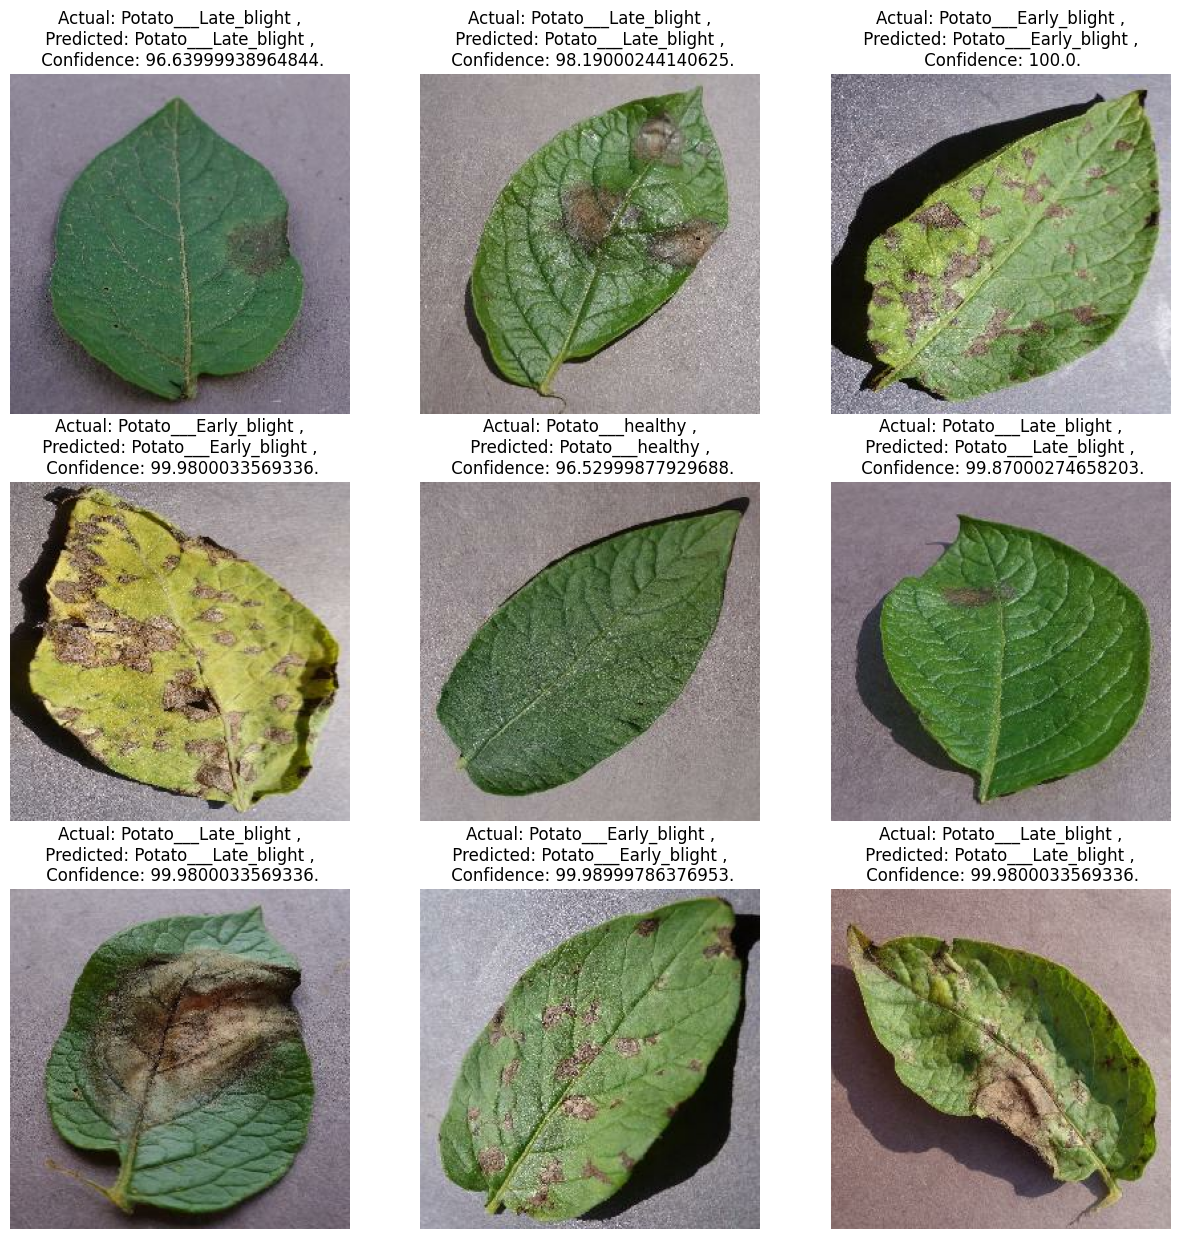

In [47]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class} ,\n Predicted: {predicted_class} , \n Confidence: {confidence}.")
        plt.axis('off')

In [58]:
    model_version = 1
    model.save(f'../models/{model_version}.keras')